In [1]:
import openmm
from functions import *
import multiprocessing
from functools import partial

In [2]:
!which pip

/mnt/home/tudomlumleart/00_VirtualEnvironments/jupyter-gpu-openmm/bin/pip


In [6]:
!python -m openmm.testInstallation


OpenMM Version: 8.1.1
Git Revision: Unknown

There are 4 Platforms available:

1 Reference - Successfully computed forces
2 CPU - Successfully computed forces
3 CUDA - Successfully computed forces
4 OpenCL - Successfully computed forces

Median difference in forces between platforms:

Reference vs. CPU: 6.29004e-06
Reference vs. CUDA: 6.73196e-06
CPU vs. CUDA: 7.3111e-07
Reference vs. OpenCL: 6.73115e-06
CPU vs. OpenCL: 7.4096e-07
CUDA vs. OpenCL: 1.74454e-07

All differences are within tolerance.


In [10]:
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")

In [11]:
import polychrom

In [12]:
# import some dependencies
import pickle, sys, os, h5py, ast, math, copy, time, scipy


import numpy as np
import numpy.matlib
import pandas as pd

import polychrom
from polychrom.starting_conformations import grow_cubic
from polychrom.hdf5_format import HDF5Reporter, list_URIs, load_URI, load_hdf5_file
from polychrom.simulation import Simulation
from polychrom import polymerutils
from polychrom import forces
from polychrom import forcekits
from scipy import spatial


In [13]:
from LEBondUpdater import bondUpdater

In [14]:
# ---------------------------#
saveFolder = r"/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/"  # Update ME
if not os.path.exists(saveFolder):
    os.mkdir(saveFolder)  # only creates folders 1 deep, won't create a full path

In [15]:
allFolders = os.listdir(saveFolder)

In [17]:
import extrusion1Dv2 as ex1D

In [33]:
numObservations = 500

In [34]:
import shutil
# ==================== general parameters  =======================

initialRunNum = 0 # can change this by reading in the number of folder
tetherLocation = np.array([ # distance = 10
                           [20, 30], # distance = 25
                           ]) # distance = 75
attractionRadiusList = [1.5]        

extraBondsLoc = []

for iT, tether in enumerate(tetherLocation):
    for iR, r in enumerate(attractionRadiusList):
        
        initialRunNum += 1
        
        run = 'run' + str(initialRunNum) 
        #  ==========Extrusion sim parameters====================
        
        density = 0.002  # density of the PBC box
        N1 = 101  # Number of monomers in the polymer
        M = 1  # separate chains in the same volume (will interact in trans with sticky sims)
        N = N1 * M  # number of monomers in the full simulation
        LIFETIME = 200 # [Imakaev/Mirny use 200 as demo] extruder lifetime
        SEPARATION = 10  # 80  ave. separation between extruders in monomer units (extruder density)
        ctcfSites = np.array([]) # np.array([0,399,400]) #CTCF site locations  # positioned on HoxA
        nCTCF = np.shape(ctcfSites)[0]
        ctcfDir = np.array([]) # 0 is bidirectional, 1 is right 2 is left
        ctcfCapture = 0.99 * np.ones(nCTCF)  # capture probability per block if capture < than this, capture
        ctcfRelease = 0.01 * np.ones(nCTCF)  # % release probability per block. if capture < than this, release
        # compartment labels
        oneChainMonomerTypes = np.zeros(N1).astype(int)
        t1, t2 = tether
        oneChainMonomerTypes[t1] = 1
        oneChainMonomerTypes[t2] = 1
        # oneChainMonomerTypes[t1-6:t1] = 1
        # oneChainMonomerTypes[t2-6:t2] = 1 # mod self interaction
        # oneChainMonomerTypes[100:150] = 2  # mod self interaction
        # create interaction matrix
        interactionMatrix = np.array([[0, 0], [0, 0]])  # === KEY parameter  ===#
        # ==== coil globule transition occurs around .7 for monomers of this length
        
        # load prob
        loadProb = np.zeros([1, N1])  # uniform loading probability
        # loadProb[0, 25:75] = 1
        # loadProb = numpy.matlib.repmat(loadProb, 1, M)  # need to replicate and renormalize
        # loadProb = loadProb / np.sum(loadProb)
        LEFNum = 0 # math.floor(N // SEPARATION )  # make 0 for no LEFs
        monomers = N1
        
        # less common parameters
        attraction_radius = r  # try making this larger; I might have to change repulsion radius too 
        num_chains = M  # simulation uses some equivalent chains  (5 in a real sim)
        MDstepsPerCohesinStep = 800
        smcBondWiggleDist = 0.2
        smcBondDist = 0.5
        angle_force = 1.5  # most sims ran with 1.5.  0 might have been better
        
        # save pars
        saveEveryBlocks = 100  # save every 10 blocks
        restartSimulationEveryBlocks = numObservations * saveEveryBlocks # blocks per iteration
        trajectoryLength = restartSimulationEveryBlocks  # 100000 # time duration of simulation (down from 100,000)
        
        # check that these loaded alright
        print(f'LEF count: {LEFNum}')
        print('interaction matrix:')
        print(interactionMatrix)
        print('monomer types:')
        print(oneChainMonomerTypes)
        print(saveFolder)
        
        # ==================== simulate epigenetic spreading
        # load polymer
        # files = list_URIs(saveFolder)
        # data = load_URI(files[-1])  # this is the full data structure, it is possible we only want data['pos']
        # run 53 is AWOL
        
        newFolder = saveFolder + run  
        lefPosFile = newFolder + "LEFPos.h5"
        if os.path.isfile(lefPosFile):
            os.remove(lefPosFile)
        if not os.path.isdir(newFolder):
            os.makedirs(newFolder)
        else:
            shutil.rmtree(newFolder)
        reporter = HDF5Reporter(folder=newFolder, max_data_length=100, check_exists=False)
        print('creating folder')
        
        # ==================================#
        # Run and load 1D simulation
        # =================================#
        
        ctcfLeftRelease = {}
        ctcfRightRelease = {}
        ctcfLeftCapture = {}
        ctcfRightCapture = {}
        
        # should modify this to allow directionality
        for i in range(M):  # loop over chains (this variable needs a better name Max)
            for t in range(len(ctcfSites)):
                pos = i * N1 + ctcfSites[t]
                if ctcfDir[t] == 0:
                    ctcfLeftCapture[pos] = ctcfCapture[t]  # if random [0,1] is less than this, capture
                    ctcfLeftRelease[pos] = ctcfRelease[t]  # if random [0,1] is less than this, release
                    ctcfRightCapture[pos] = ctcfCapture[t]
                    ctcfRightRelease[pos] = ctcfRelease[t]
                elif ctcfDir[t] == 1:  # stop Cohesin moving toward the right
                    ctcfLeftCapture[pos] = 0
                    ctcfLeftRelease[pos] = 1
                    ctcfRightCapture[pos] = ctcfCapture[t]
                    ctcfRightRelease[pos] = ctcfRelease[t]
                elif ctcfDir[t] == 2:
                    ctcfLeftCapture[pos] = ctcfCapture[t]  # if random [0,1] is less than this, capture
                    ctcfLeftRelease[pos] = ctcfRelease[t]  # if random [0,1] is less than this, release
                    ctcfRightCapture[pos] = 0
                    ctcfRightRelease[pos] = 1
        
        args = {}
        args["ctcfRelease"] = {-1: ctcfLeftRelease, 1: ctcfRightRelease}
        args["ctcfCapture"] = {-1: ctcfLeftCapture, 1: ctcfRightCapture}
        args["N"] = N
        args["LIFETIME"] = LIFETIME
        args["LIFETIME_STALLED"] = LIFETIME  # no change in lifetime when stalled
        
        occupied = np.zeros(N)
        occupied[0] = 1  # (I think this is just prevent the cohesin loading at the end by making it already occupied)
        occupied[-1] = 1  # [-1] is "python" for end
        cohesins = []
        
        print('starting simulation with N LEFs=')
        print(LEFNum)
        for i in range(LEFNum):
            ex1D.loadOneFromDist(cohesins, occupied, args, loadProb)  # load the cohesins
        
        with h5py.File(lefPosFile, mode='a') as myfile:
            dset = myfile.create_dataset("positions",
                                         shape=(trajectoryLength, LEFNum, 2),
                                         dtype=np.int32,
                                         compression="gzip")
            steps = 100  # saving in 50 chunks because the whole trajectory may be large
            bins = np.linspace(0, trajectoryLength, steps, dtype=int)  # chunks boundaries
            for st, end in zip(bins[:-1], bins[1:]):
                cur = []
                for i in range(st, end):
                    ex1D.translocate(cohesins, occupied, args, loadProb)  # actual step of LEF dynamics
                    positions = [(cohesin.left.pos, cohesin.right.pos) for cohesin in cohesins]
                    cur.append(positions)  # appending current positions to an array
                cur = np.array(cur)  # when we finished a block of positions, save it to HDF5
                dset[st:end] = cur
            myfile.attrs["N"] = N
            myfile.attrs["LEFNum"] = LEFNum
        
        # =========== Load LEF simulation ===========#
        trajectory_file = h5py.File(lefPosFile, mode='r')
        LEFNum = trajectory_file.attrs["LEFNum"]  # number of LEFs
        LEFpositions = trajectory_file["positions"]  # array of LEF positions
        steps = MDstepsPerCohesinStep  # MD steps per step of cohesin  (set to ~800 in real sims)
        Nframes = LEFpositions.shape[0]  # length of the saved trajectory (>25000 in real sims)
        print(f'Length of the saved trajectory: {Nframes}')
        block = 0  # starting block
        
        # test some properties
        # assertions for easy managing code below
        assert (Nframes % restartSimulationEveryBlocks) == 0
        assert (restartSimulationEveryBlocks % saveEveryBlocks) == 0
        
        savesPerSim = restartSimulationEveryBlocks // saveEveryBlocks
        simInitsTotal = (Nframes) // restartSimulationEveryBlocks
        # concatinate monomers if needed
        if len(oneChainMonomerTypes) != N:
            monomerTypes = np.tile(oneChainMonomerTypes, num_chains)
        else:
            monomerTypes = oneChainMonomerTypes
        
        N_chain = len(oneChainMonomerTypes)
        N = len(monomerTypes)
        print(f'N_chain: {N_chain}')  # ~8000 in a real sim
        print(f'N: {N}')  # ~40000 in a real sim
        N_traj = trajectory_file.attrs["N"]
        print(f'N_traj: {N_traj}')
        assert N == trajectory_file.attrs["N"]
        print(f'Nframes: {Nframes}')
        print(f'simInitsTotal: {simInitsTotal}')
        
        # ==============================================================#
        #                  RUN 3D simulation                              #
        # ==============================================================#
        # Initial simulation using fixed input states
        t = 0
        LEFsubset = LEFpositions[t * restartSimulationEveryBlocks:(t + 1) * restartSimulationEveryBlocks, :,
                    :]  # a subset of the total LEF simulation time
        milker = bondUpdater(LEFsubset)
        data = grow_cubic(N, int((N / (density * 1.2)) ** 0.333), method="linear")  # starting conformation
        PBC_width = (N / density) ** 0.333
        chains = [(N_chain * (k), N_chain * (k + 1), False) for k in range(num_chains)]  # now i
        reporter = HDF5Reporter(folder=newFolder, max_data_length=100)
        a = Simulation(N=N,
                       error_tol=0.01,
                       collision_rate=0.02,
                       integrator="variableLangevin",
                       platform="CUDA",
                       GPU="0",
                       PBCbox=False, # turn off bounding box
                       reporters=[reporter],
                       precision="mixed")  # platform="CPU", # GPU="1"
        
        a.set_data(data)  # initial polymer
        a.add_force(
            polychrom.forcekits.polymer_chains(
                a,
                chains=chains,
                nonbonded_force_func=polychrom.forces.heteropolymer_SSW,
                nonbonded_force_kwargs={
                    'attractionEnergy': 0,  # base attraction energy for all monomers
                    'attractionRadius': attraction_radius,
                    'interactionMatrix': interactionMatrix,
                    'monomerTypes': monomerTypes,
                    'extraHardParticlesIdxs': []
                },
                bond_force_kwargs={
                    'bondLength': 1,
                    'bondWiggleDistance': 0.05
                },
                angle_force_kwargs={
                    'k': angle_force
                },
                extra_bonds = extraBondsLoc
            )
        )
        # ------------ initializing milker; adding bonds ---------
        kbond = a.kbondScalingFactor / (smcBondWiggleDist ** 2)
        bondDist = smcBondDist * a.length_scale
        activeParams = {"length": bondDist, "k": kbond}
        inactiveParams = {"length": bondDist, "k": 0}
        milker.setParams(activeParams, inactiveParams)
        milker.setup(bondForce=a.force_dict['harmonic_bonds'],
                     blocks=restartSimulationEveryBlocks)
        
        # If your simulation does not start, consider using energy minimization below
        a.local_energy_minimization()  # only do this at the beginning
        
        # this runs
        for i in range(restartSimulationEveryBlocks):  # loops over 100
            if i % saveEveryBlocks == (saveEveryBlocks - 1):
                a.do_block(steps=steps)
            else:
                a.integrator.step(steps)  # do steps without getting the positions from the GPU (faster)
            if i < restartSimulationEveryBlocks - 1:
                curBonds, pastBonds = milker.step(a.context)  # this updates bonds. You can do something with bonds here
        data = a.get_data()  # save data and step, and delete the simulation
        del a
        reporter.blocks_only = True  # Write output hdf5-files only for blocks
        time.sleep(0.2)  # wait 200ms for sanity (to let garbage collector do its magic)
        reporter.dump_data()

# ---


LEF count: 0
interaction matrix:
[[0 0]
 [0 0]]
monomer types:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/
creating folder
starting simulation with N LEFs=
0
Length of the saved trajectory: 50000
N_chain: 101
N: 101
N_traj: 101
Nframes: 50000
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:Particles loaded. Potential energy is 1.410815
INFO:root:before minimization eK=1.513363779362141, eP=1.4108151179134265, time=0.0 ps


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 100


INFO:root:Particles loaded. Potential energy is 0.162884
INFO:root:after minimization eK=1.513363779362141, eP=0.06920601512867423, time=0.0 ps
INFO:root:block    0 pos[1]=[10.0 27.5 24.9] dr=21.93 t=8529.7ps kin=2.34 pot=1.89 Rg=11.039 SPS=26843 dt=107.3fs dx=36.69pm 
INFO:root:block    1 pos[1]=[12.8 9.1 21.6] dr=21.47 t=16933.5ps kin=2.98 pot=2.57 Rg=7.262 SPS=26811 dt=102.8fs dx=39.65pm 
INFO:root:block    2 pos[1]=[-21.0 6.9 27.8] dr=27.04 t=25483.0ps kin=2.70 pot=1.78 Rg=8.353 SPS=26645 dt=102.8fs dx=37.71pm 
INFO:root:block    3 pos[1]=[-38.5 10.4 56.3] dr=32.75 t=33990.5ps kin=3.05 pot=2.61 Rg=5.395 SPS=26433 dt=98.5fs dx=38.43pm 
INFO:root:block    4 pos[1]=[-28.1 15.5 66.2] dr=16.37 t=42496.7ps kin=2.06 pot=1.92 Rg=9.321 SPS=26228 dt=103.6fs dx=33.22pm 
INFO:root:block    5 pos[1]=[-37.5 -0.0 91.6] dr=26.93 t=51034.7ps kin=2.11 pot=1.60 Rg=9.622 SPS=26986 dt=104.3fs dx=33.83pm 
INFO:root:block    6 pos[1]=[-38.4 -16.2 103.5] dr=24.26 t=59589.3ps kin=2.32 pot=1.94 Rg=9.304 SPS

In [2]:
save_folder = r"/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/testFunction/"

In [3]:
generate_polymer_chain(num_monomers=100, num_polymers=1, num_observations=10, save_folder=save_folder)

INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


LEF count: 0
interaction matrix:
[[0]]
monomer types:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/testFunction/
creating folder
starting simulation with N LEFs=
0
Length of the saved trajectory: 1000
N_chain: 100
N: 100
N_traj: 100
Nframes: 1000
simInitsTotal: 1
Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 1.461936
INFO:root:before minimization eK=1.4056936195645904, eP=1.4619360222509763, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.179917
INFO:root:after minimization eK=1.4056936195645904, eP=0.05869508666764771, time=0.0 ps
INFO:root:block    0 pos[1]=[18.5 11.4 -0.9] dr=8.99 t=8528.5ps kin=1.88 pot=1.62 Rg=8.940 SPS=30732 dt=113.8fs dx=34.85pm 
INFO:root:block    1 pos[1]=[23.7 28.5 -12.1] dr=29.19 t=17005.4ps kin=2.12 pot=2.05 Rg=8.839 SPS=29382 dt=113.4fs dx=36.83pm 
INFO:root:block    2 pos[1]=[9.7 33.4 8.5] dr=16.12 t=25414.0ps kin=2.29 pot=2.12 Rg=11.683 SPS=30755 dt=102.4fs dx=34.59pm 
INFO:root:block    3 pos[1]=[2.8 37.9 -29.7] dr=39.33 t=33880.8ps kin=2.07 pot=1.89 Rg=7.576 SPS=28921 dt=108.0fs dx=34.72pm 
INFO:root:block    4 pos[1]=[7.7 -3.5 -46.9] dr=40.87 t=42317.4ps kin=1.84 pot=2.04 Rg=9.615 SPS=30499 dt=113.5fs dx=34.35pm 
INFO:root:block    5 pos[1]=[-32.9 13.0 -81.4] dr=35.53 t=50778.1ps kin=2.35 pot=2

In [4]:
# The function works! Try loading the data
URIs = polychrom.hdf5_format.list_URIs(save_folder)

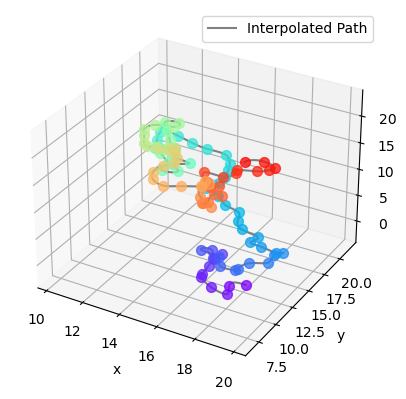

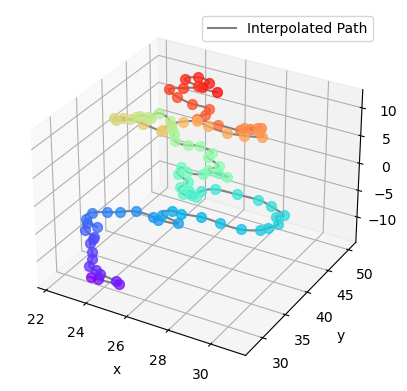

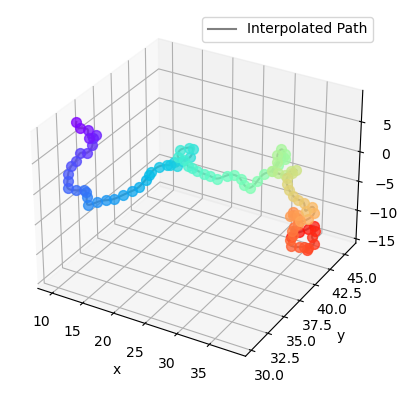

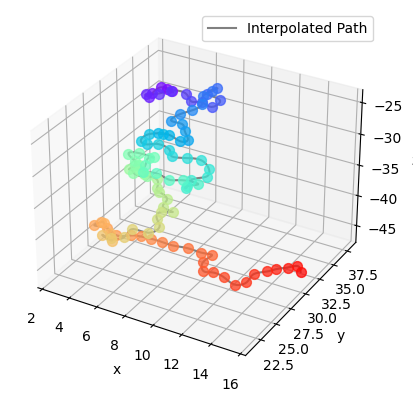

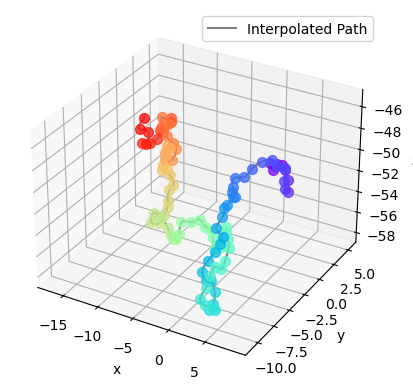

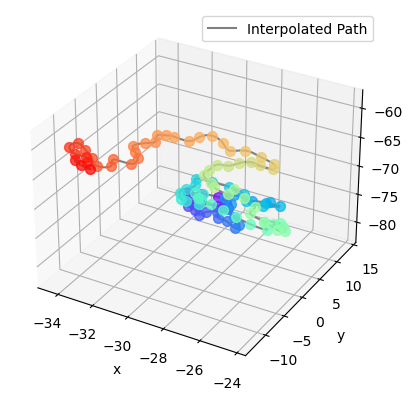

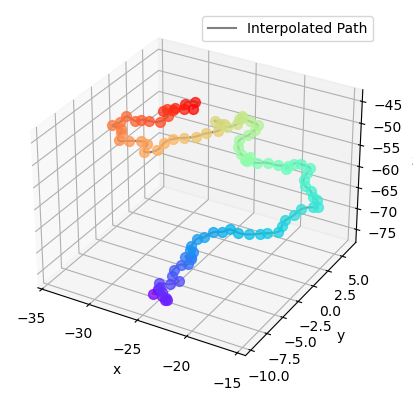

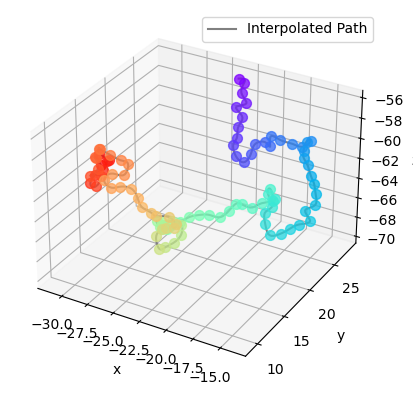

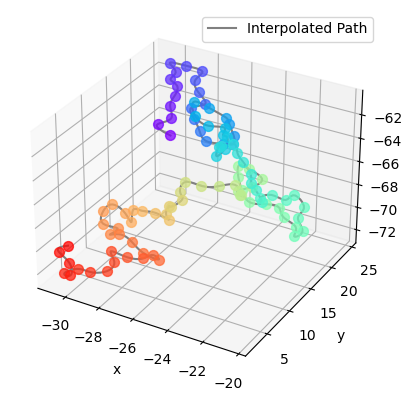

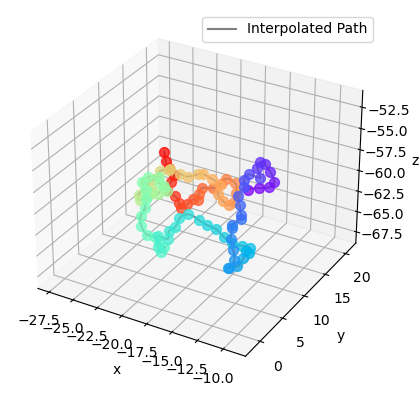

In [6]:
for URI in URIs:
    data = polychrom.hdf5_format.load_URI(URI)
    xyz = data["pos"]
    visualize_polymer(xyz)

In [7]:
save_folder =  r"/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/testSticky_1/"

In [12]:
monomer_types = np.zeros(100).astype(int)
monomer_types.shape
monomer_types[[45, 55]] = 1
interaction_matrix = np.zeros([2, 2])
interaction_matrix[1, 1] = 0.9

In [2]:
generate_polymer_chain(num_monomers=100, num_polymers=1, num_observations=10, save_folder=save_folder,
                       monomer_types=monomer_types, interaction_matrix=interaction_matrix)

NameError: name 'save_folder' is not defined

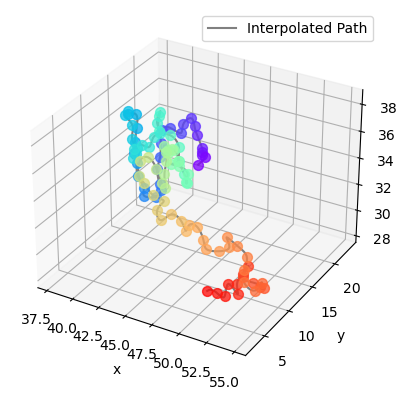

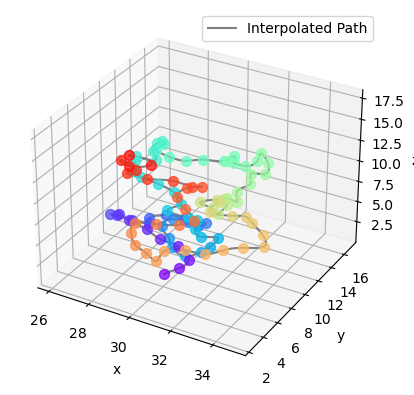

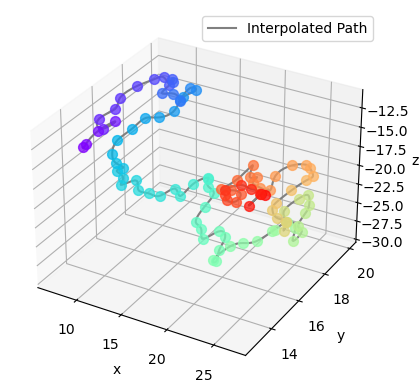

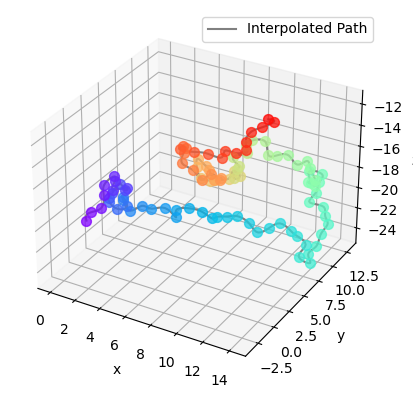

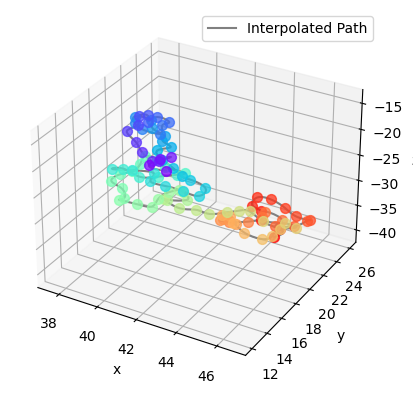

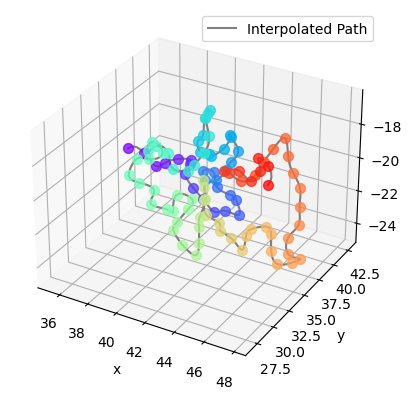

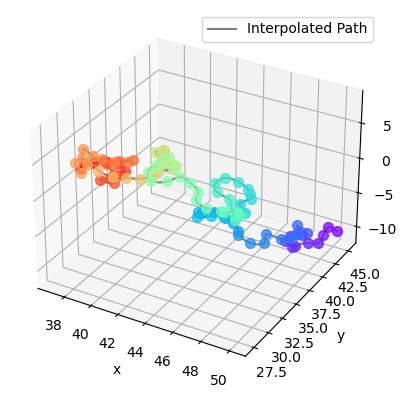

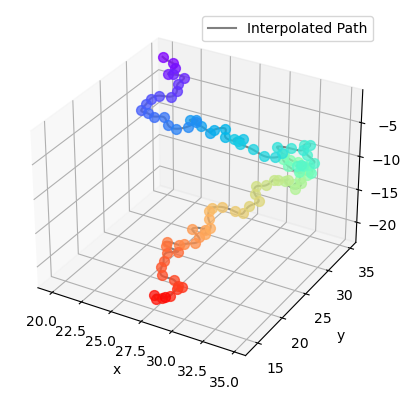

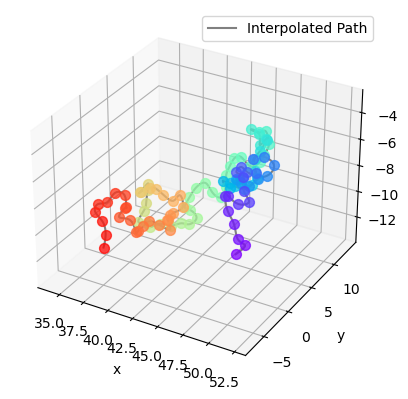

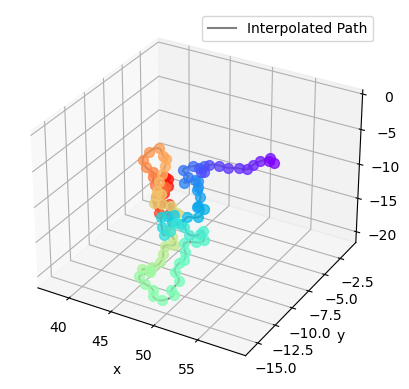

In [15]:
URIs = polychrom.hdf5_format.list_URIs(save_folder)
for URI in URIs:
    data = polychrom.hdf5_format.load_URI(URI)
    xyz = data["pos"]
    visualize_polymer(xyz)

In [17]:
dmaps = np.zeros([100, 100, 10])
for i, URI in enumerate(URIs):
    data = polychrom.hdf5_format.load_URI(URI)
    xyz = data["pos"]
    dmaps[:, :, i] = squareform(pdist(xyz))

In [18]:
dmap_median = np.median(dmaps, axis=2)

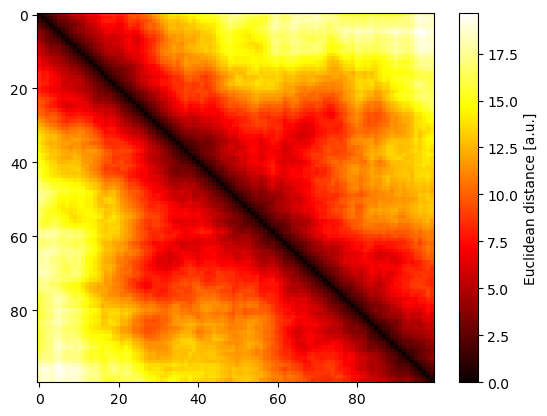

In [23]:
heatmap1 = plt.imshow(dmap_median, cmap='hot', aspect='auto')
cb1 = plt.colorbar(heatmap1)
cb1.set_label('Euclidean distance [a.u.]')

In [22]:
# Try loop extrusion simulations 
num_monomers = 100
num_polymers = 1
num_observations = 10
save_folder = r"/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/testLoopExtrusion_1/"
ctcf_sites = [30, 70]
ctcf_directions = [1, 2]
num_lef = 10 

generate_polymer_chain(num_monomers=num_monomers, 
                       num_polymers=num_polymers, 
                       num_observations=num_observations, 
                       save_folder=save_folder,
                       ctcf_sites=ctcf_sites, 
                       ctcf_directions = ctcf_directions,
                       num_lef=num_lef)

INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


[[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
  0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
  0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
  0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
  0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
  0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
  0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
  0.01 0.01]]
LEF count: 10
interaction matrix:
[[0]]
monomer types:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/testLoopExtrusion_1/
creating folder
starting simulation with N LEFs=
10
Length of the saved trajectory: 1000
N_chain: 100
N: 100
N_traj: 100
Nframes: 1000
simInitsTotal: 

INFO:root:Particles loaded. Potential energy is 4.819683
INFO:root:before minimization eK=1.610901275991629, eP=4.819683281359274, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.889616
INFO:root:after minimization eK=1.610901275991629, eP=0.7994242838775234, time=0.0 ps
INFO:root:block    0 pos[1]=[9.0 20.8 5.4] dr=16.95 t=8563.7ps kin=2.41 pot=2.70 Rg=4.610 SPS=26153 dt=100.3fs dx=34.78pm 
INFO:root:block    1 pos[1]=[-0.8 7.3 -0.7] dr=18.14 t=17158.8ps kin=2.44 pot=2.51 Rg=4.585 SPS=28520 dt=105.6fs dx=36.88pm 
INFO:root:block    2 pos[1]=[22.1 -20.4 -20.9] dr=41.34 t=25756.8ps kin=1.96 pot=2.21 Rg=5.044 SPS=28472 dt=108.1fs dx=33.83pm 
INFO:root:block    3 pos[1]=[16.3 -22.2 -22.5] dr=9.64 t=34286.7ps kin=2.47 pot=3.15 Rg=4.656 SPS=26153 dt=101.7fs dx=35.68pm 
INFO:root:block    4 pos[1]=[13.6 -25.4 -31.3] dr=14.80 t=42786.7ps kin=1.83 pot=1.94 Rg=5.200 SPS=26090 dt=112.1fs dx=33.88pm 
INFO:root:block    5 pos[1]=[-10.1 -36.9 -39.1] dr=28.60 t=51284.8ps kin=2.17 pot=2

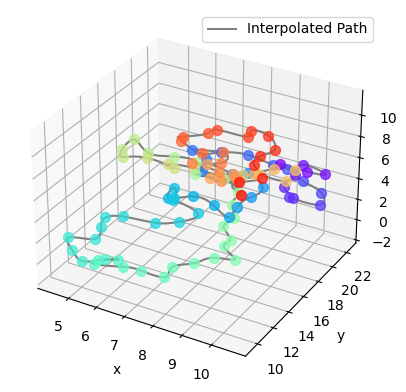

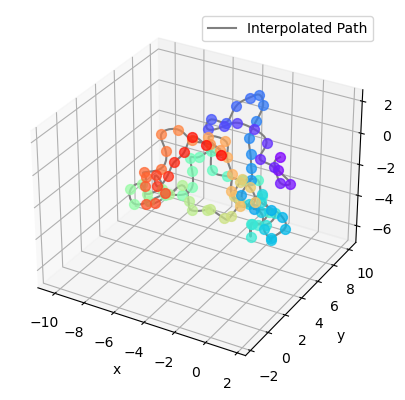

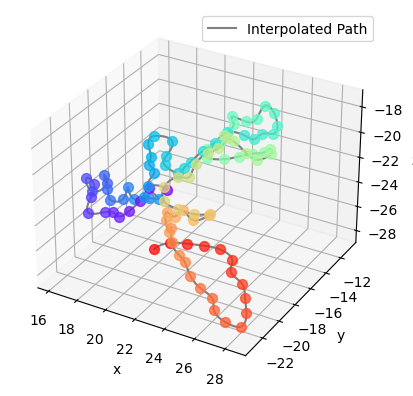

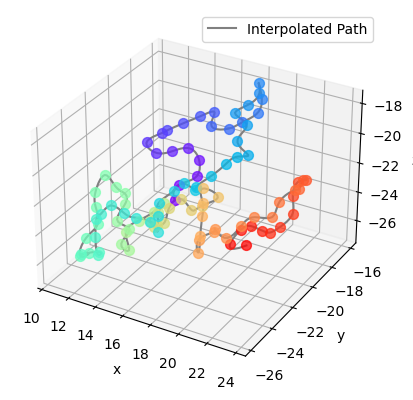

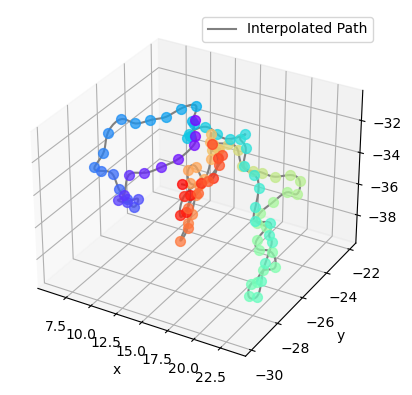

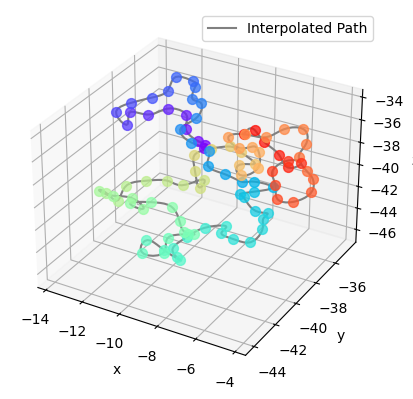

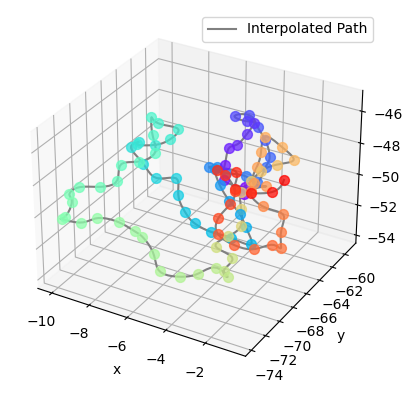

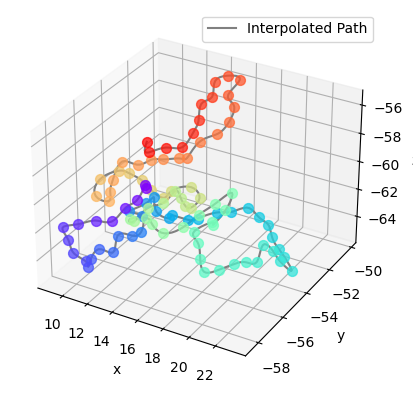

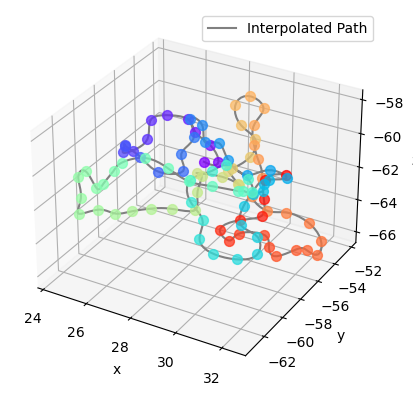

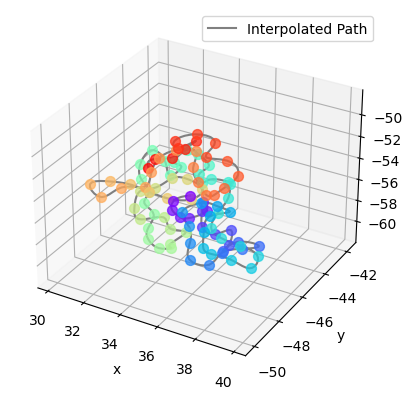

In [23]:
URIs = polychrom.hdf5_format.list_URIs(save_folder)
for URI in URIs:
    data = polychrom.hdf5_format.load_URI(URI)
    xyz = data["pos"]
    visualize_polymer(xyz)

In [24]:
dmaps = np.zeros([100, 100, 10])
for i, URI in enumerate(URIs):
    data = polychrom.hdf5_format.load_URI(URI)
    xyz = data["pos"]
    dmaps[:, :, i] = squareform(pdist(xyz))

In [25]:
dmap_median = np.median(dmaps, axis=2)

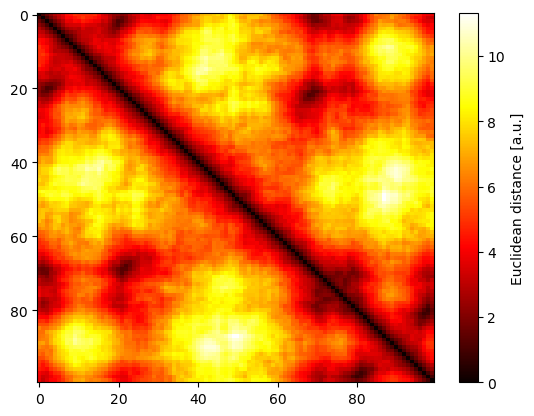

In [26]:
heatmap1 = plt.imshow(dmap_median, cmap='hot', aspect='auto')
cb1 = plt.colorbar(heatmap1)
cb1.set_label('Euclidean distance [a.u.]')

In [2]:
# Try loop extrusion simulations 
num_monomers = 100
num_polymers = 1
num_observations = 500
ctcf_directions = [1, 2]
num_lef = 10 



In [3]:
ctcf_site_params = [[45, 55], [35, 65], [25, 75], [15, 85]]
save_folder_params =  [r"/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/LoopExtrusion_{}/".format(i) for i in range(len(ctcf_site_params))]

In [4]:
params = [x for x in zip(ctcf_site_params, save_folder_params)]

In [7]:
partial_function = partial(generate_polymer_chain, 
                       num_monomers=num_monomers, 
                       num_polymers=num_polymers, 
                       num_observations=num_observations, 
                       ctcf_directions = ctcf_directions,
                       num_lef=num_lef)

In [11]:
def partial_helper(param):
    return partial_function(ctcf_sites=param[0],
                            save_folder=param[1])

In [12]:
with multiprocessing.Pool(processes=4) as pool:
    pool.map(partial_helper, params)

[[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
  0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
  0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
  0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
  0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
  0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
  0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
  0.01 0.01]][[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
  0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
  0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
  0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
  0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
  0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
  0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01

Length of the saved trajectory: 50000
N_chain: 100
N: 100
N_traj: 100
Nframes: 50000
simInitsTotal: 1
Length of the saved trajectory: 50000Length of the saved trajectory: 50000

N_chain: 100N_chain: 100

N: 100N: 100

N_traj: 100N_traj: 100

Nframes: 50000Nframes: 50000

simInitsTotal: 1simInitsTotal: 1

Length of the saved trajectory: 50000
N_chain: 100
N: 100
N_traj: 100
Nframes: 50000
simInitsTotal: 1
Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99
Exclude neighbouring chain particles from heteropolymer_SSW
Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99Number of exceptions:
 99
Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:Particles loaded. Potential energy is 5.434739
INFO:root:before minimization eK=1.4413991962054336, eP=5.434738563127098, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.913233
INFO:root:after minimization eK=1.4413991962054336, eP=0.8162168265317199, time=0.0 ps
INFO:root:block    0 pos[1]=[23.2 21.9 14.9] dr=14.36 t=8536.6ps kin=2.56 pot=2.90 Rg=3.758 SPS=25969 dt=100.5fs dx=35.90pm 
INFO:root:block    1 pos[1]=[18.7 40.9 3.2] dr=24.27 t=17157.6ps kin=1.89 pot=2.15 Rg=3.736 SPS=25983 dt=108.7fs dx=33.36pm 
INFO:root:block    2 pos[1]=[26.8 36.1 -13.5] dr=18.51 t=25684.2ps kin=1.70 pot=2.05 Rg=4.527 SPS=25945 dt=118.4fs dx=34.49pm 
INFO:root:block    3 pos[1]=[25.7 36.7 -3.4] dr=9.43 t=34255.6ps kin=2.09 pot=2.51 Rg=4.352 SPS=25937 dt=104.4fs dx=33.69pm 
INFO:root:block    4 pos[1]=[48.7 49.8 -5.5] dr=2